>Name: Lillian Mansour   
>ID: 211623806

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, models
import torch
from torch.utils.data import Dataset
import pandas as pd
import random
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
import os
import zipfile
from tqdm import tqdm
import random
import itertools
from torch.utils.data import Subset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

> Creating CSV files (no need to run this cell) :

In [ ]:
corrupted = ['3917.jpg', '41945.jpg', '79499.jpg', '91033.jpg', '92899.jpg', '95347.jpg', '101947.jpg', '20153.jpg', '18649.jpg', '100532.jpg']
data = pd.read_csv("/content/drive/MyDrive/Colab/Deep_Learning/Project/all_data_info.csv")

train_dataset = data[data['in_train'] == 1]
test_dataset = data[data['in_train'] == 0]

train_artists = train_dataset['artist'].unique()
test_artists = test_dataset['artist'].unique()

unique_train_artists = set(train_artists) - set(test_artists)
unique_test_artists = set(test_artists) - set(train_artists)
unique_train_artists = list(unique_train_artists)
unique_valid_artists = random.sample(unique_train_artists, int(0.2 * len(unique_train_artists)))
unique_train_artists = set(unique_train_artists) - set(unique_valid_artists)

train_dataset_filtered = train_dataset[train_dataset['artist'].isin(unique_train_artists)]

test_dataset_filtered = test_dataset[test_dataset['artist'].isin(unique_test_artists)]

def generate_image_pairs(dataframe, unique_artists, max_images=10):
    dataframe = dataframe[~dataframe['new_filename'].isin(corrupted)]
    df_filtered = dataframe[dataframe['artist'].isin(unique_artists)]

    combinations = []
    for artist in unique_artists:
        artist_images = df_filtered[df_filtered['artist'] == artist]['new_filename'].sample(n=min(max_images, len(df_filtered[df_filtered['artist'] == artist]))).tolist()
        if len(artist_images) > 1:
            artist_combos = list(itertools.combinations(artist_images, 2))
            for combo in artist_combos:
                different_artist_images = df_filtered[df_filtered['artist'] != artist]['new_filename'].sample(n=1).tolist()
                if different_artist_images:
                    combinations.append([combo[0], combo[1], different_artist_images[0]])

    columns = ['image1', 'image2', 'image3']
    combo_df = pd.DataFrame(combinations, columns=columns)
    return df_filtered, combo_df

# train_dataframe, train_data = generate_image_pairs(train_dataset, unique_train_artists)
# valid_dataframe, valid_data = generate_image_pairs(train_dataset, unique_valid_artists)
# test_dataframe, test_data = generate_image_pairs(test_dataset, unique_test_artists)

# train_data.to_csv('/content/drive/MyDrive/Colab/Deep_Learning/Project/train_data.csv', index=False)
# valid_data.to_csv('/content/drive/MyDrive/Colab/Deep_Learning/Project/valid_data.csv', index=False)
# test_data.to_csv('/content/drive/MyDrive/Colab/Deep_Learning/Project/test_data.csv', index=False)

>Preparing a center cropped images (no need to run this cell) :

In [ ]:
def process_images(input_zip_path, output_zip_path, output_dir):
    !unzip -q $input_zip_path -d input_images

    os.makedirs(output_dir, exist_ok=True)

    for filename in os.listdir("input_images"):
        if filename.endswith(".jpg"):
            with Image.open(os.path.join("input_images", filename)) as img:
                center_cropper = transforms.CenterCrop(224)
                cropped_img = center_cropper(img)
                cropped_img.save(os.path.join(output_dir, filename))

    with zipfile.ZipFile(output_zip_path, "w") as zip_ref:
        for root, dirs, files in os.walk(output_dir):
            for file in files:
                zip_ref.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), output_dir))

train_zip_path = "/content/drive/MyDrive/yalla/train.zip"
test_zip_path = "/content/drive/MyDrive/yalla/test.zip"

cropped_train_zip_path = "/content/drive/MyDrive/Colab/Deep_Learning/Project/center_cropped_train.zip"
cropped_test_zip_path = "/content/drive/MyDrive/Colab/Deep_Learning/Project/center_cropped_test.zip"

# process_images(train_zip_path, cropped_train_zip_path, "center_cropped_train")
# process_images(test_zip_path, cropped_test_zip_path, "center_cropped_test")

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, path, dataframe, flag):
        self.dataframe = dataframe
        self.flag = flag
        self.archive = path
        self.transform = transforms.Compose([
                                               transforms.RandomRotation(15),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.RandomVerticalFlip(),
                                               transforms.RandomAffine(15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=15),

                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, item):
        img1 = self.dataframe['image1'][item]
        img2 = self.dataframe['image2'][item]
        img3 = self.dataframe['image3'][item]


        if self.flag:
          datum1 =  self.load_transform_image(img1)
          datum2 = self.load_transform_image(img2)
          datum3 = self.load_transform_image(img3)
        else:
          datum1 = self.load_image(img1)
          datum2 = self.load_image(img2)
          datum3 = self.load_image(img3)

        return datum1, datum2, datum3

    def load_image(self, img_name):
        image = Image.open(self.archive +"/"+ img_name).convert('RGB')
        image = self.image_transformer_nn(image)
        return image

    def load_transform_image(self, img_name):
        image = Image.open(self.archive +"/"+ img_name).convert('RGB')
        image = self.transform(image).float()
        return image

    def image_transformer_nn(self, image):
        tensoring = transforms.ToTensor()
        image = tensoring(image)
        normalizer = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        image = normalizer(image)
        return image

>Change the paths to fit your needs.

In [ ]:
# Data path
train_dataframe = pd.read_csv('/content/drive/MyDrive/Colab/Deep_Learning/Project/train_data.csv')
val_dataframe = pd.read_csv('/content/drive/MyDrive/Colab/Deep_Learning/Project/valid_data.csv')
test_dataframe = pd.read_csv('/content/drive/MyDrive/Colab/Deep_Learning/Project/test_data.csv')

# Cropped images path
cropped_train_path = '/content/drive/MyDrive/Colab/Deep_Learning/Project/center_cropped_train.zip'
cropped_test_path = '/content/drive/MyDrive/Colab/Deep_Learning/Project/center_cropped_test.zip'

train_path = '/content/train'
test_path = '/content/test'

!unzip $cropped_train_path -d $train_path
!unzip $cropped_test_path -d $test_path

train_data = ImageDataset(train_path, train_dataframe, 1)
valid_data = ImageDataset(train_path, val_dataframe, 0)
test_data = ImageDataset(test_path, test_dataframe, 0)


train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=128, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True)

In [ ]:
class TripletNetwork(nn.Module):
    def __init__(self, embedding_size=256):
        super(TripletNetwork, self).__init__()
        resnet18 = models.resnet18(pretrained=True)
        num_ftrs = resnet18.fc.in_features
        resnet18.fc = nn.Linear(num_ftrs, embedding_size)

        self.resnet18 = resnet18

    def forward(self, img1, img2, img3):
        embedding1 = self.resnet18(img1)
        embedding2 = self.resnet18(img2)
        embedding3 = self.resnet18(img3)
        return embedding1, embedding2, embedding3

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=4.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = torch.norm(anchor - positive, p=2, dim=1)
        distance_negative = torch.norm(anchor - negative, p=2, dim=1)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean(), distance_positive, distance_negative

In [ ]:
model = TripletNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
loss_fn = TripletLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def plot(train_counter, train_losses, valid_counter, valid_losses, valid_accuracies, train_accuracies):
  fig = plt.figure(figsize=(8, 5))
  plt.plot(train_counter, train_losses, color='blue')
  plt.plot(valid_counter, valid_losses, color='red')
  plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
  plt.xlabel('number of epoch')
  plt.ylabel('loss')
  plt.show()

  fig = plt.figure(figsize=(8, 5))
  plt.plot(valid_counter, train_accuracies, color='green')
  plt.plot(train_counter, valid_accuracies, color='purple')
  plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='upper right')
  plt.xlabel('number of epoch')
  plt.ylabel('accuracy')
  plt.show()

100%|██████████| 150/150 [05:31<00:00,  2.21s/it]


Train- Epoch [1/15], Loss: 2.9193, Accuracy: 71.2235


100%|██████████| 38/38 [00:43<00:00,  1.14s/it]


Validation- Epoch [1/15], Loss: 2.3003, Accuracy: 76.3563


100%|██████████| 31/31 [00:33<00:00,  1.07s/it]

Test- Epoch [1/15], Loss: 2.4998, Accuracy : 73.4484%


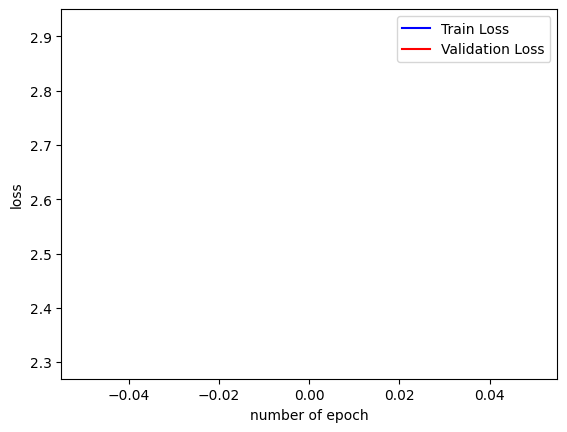

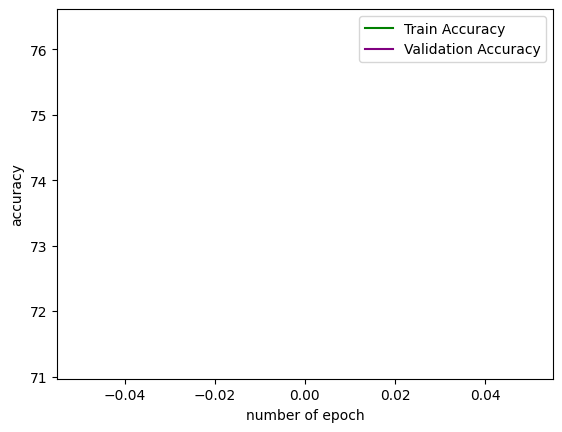

100%|██████████| 150/150 [05:22<00:00,  2.15s/it]


Train- Epoch [2/15], Loss: 2.2237, Accuracy: 77.5141


100%|██████████| 38/38 [00:39<00:00,  1.05s/it]


Validation- Epoch [2/15], Loss: 2.0252, Accuracy: 78.3407


100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Test- Epoch [2/15], Loss: 2.2454, Accuracy : 76.0494%


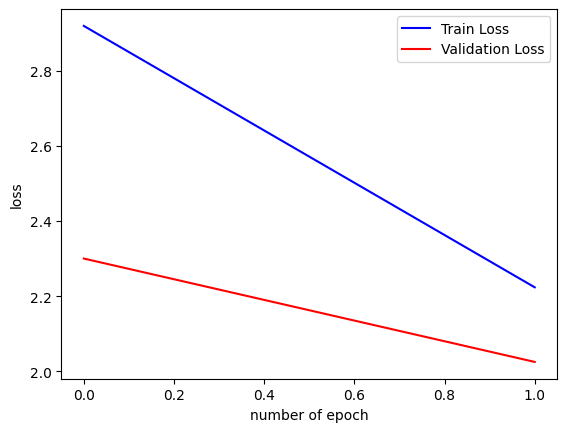

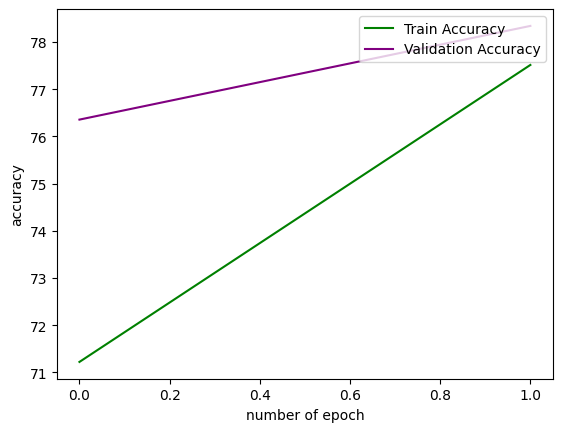

100%|██████████| 150/150 [05:22<00:00,  2.15s/it]


Train- Epoch [3/15], Loss: 1.9610, Accuracy: 80.0492


100%|██████████| 38/38 [00:43<00:00,  1.13s/it]


Validation- Epoch [3/15], Loss: 1.9048, Accuracy: 79.2907


100%|██████████| 31/31 [00:33<00:00,  1.08s/it]


Test- Epoch [3/15], Loss: 2.1352, Accuracy : 76.7190%


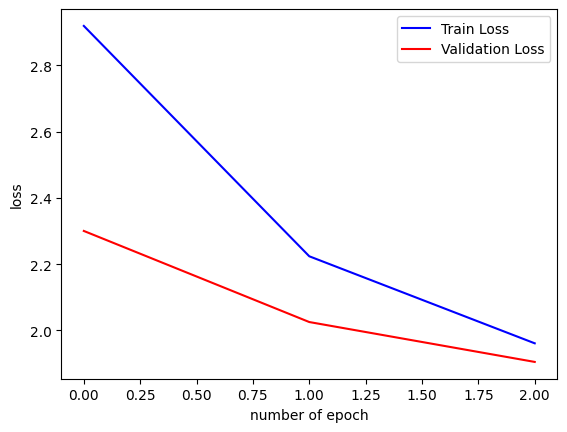

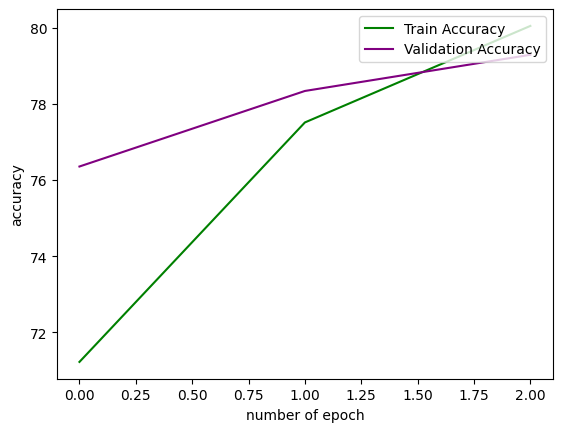

100%|██████████| 150/150 [05:23<00:00,  2.16s/it]


Train- Epoch [4/15], Loss: 1.7764, Accuracy: 81.8144


100%|██████████| 38/38 [00:39<00:00,  1.05s/it]


Validation- Epoch [4/15], Loss: 1.8622, Accuracy: 79.5862


100%|██████████| 31/31 [00:32<00:00,  1.06s/it]


Test- Epoch [4/15], Loss: 2.0820, Accuracy : 77.6977%


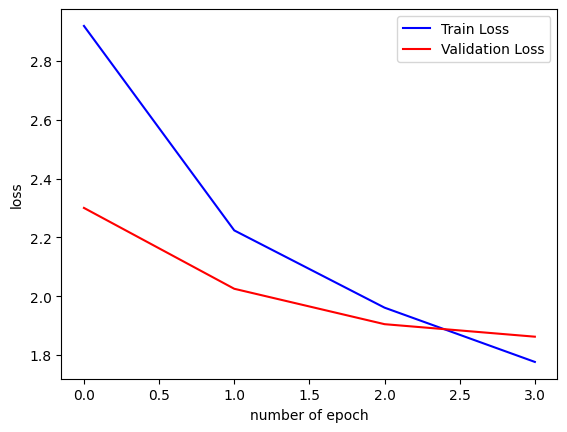

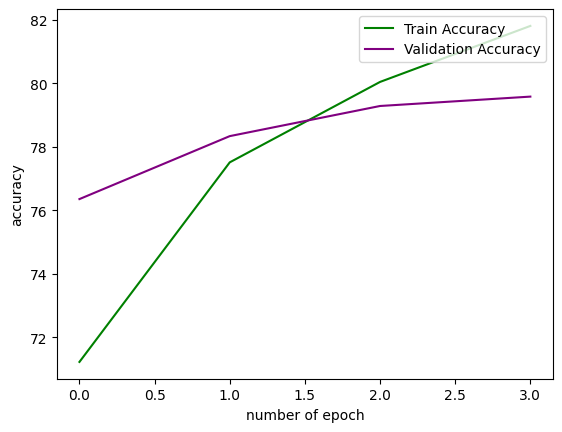

100%|██████████| 150/150 [05:22<00:00,  2.15s/it]


Train- Epoch [5/15], Loss: 1.6761, Accuracy: 82.7624


100%|██████████| 38/38 [00:44<00:00,  1.16s/it]


Validation- Epoch [5/15], Loss: 1.8095, Accuracy: 79.7551


100%|██████████| 31/31 [00:33<00:00,  1.07s/it]

Test- Epoch [5/15], Loss: 2.0293, Accuracy : 78.2385%


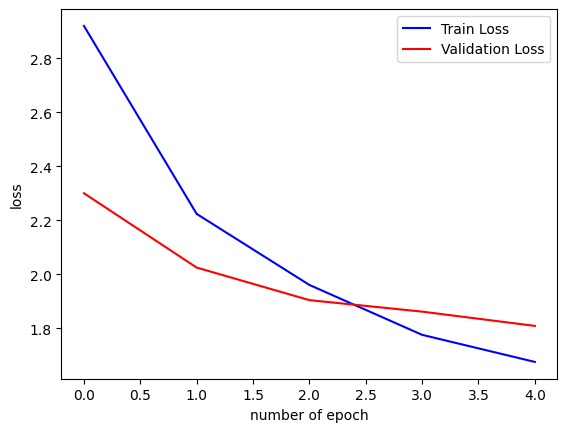

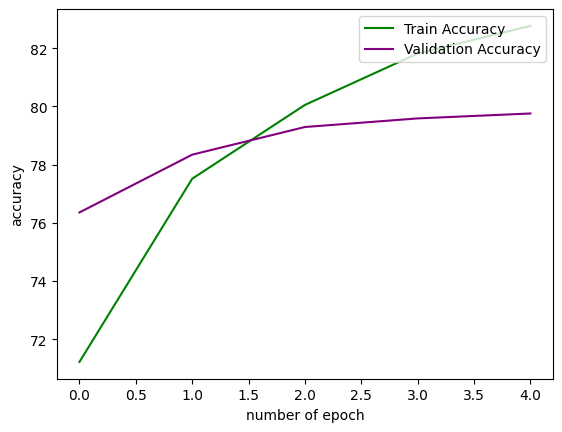

100%|██████████| 150/150 [05:22<00:00,  2.15s/it]


Train- Epoch [6/15], Loss: 1.5748, Accuracy: 84.1557


100%|██████████| 38/38 [00:40<00:00,  1.06s/it]


Validation- Epoch [6/15], Loss: 1.7982, Accuracy: 80.3884


100%|██████████| 31/31 [00:32<00:00,  1.06s/it]


Test- Epoch [6/15], Loss: 2.0149, Accuracy : 78.5733%


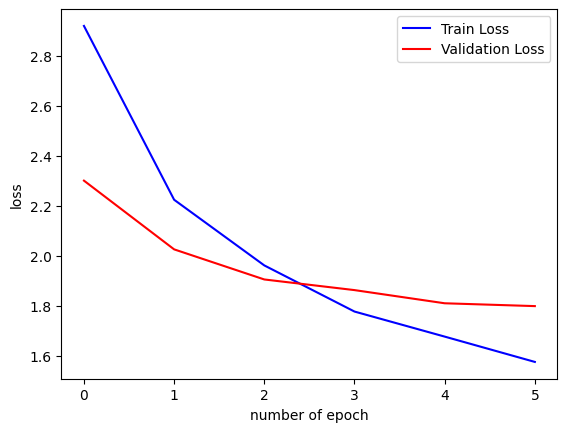

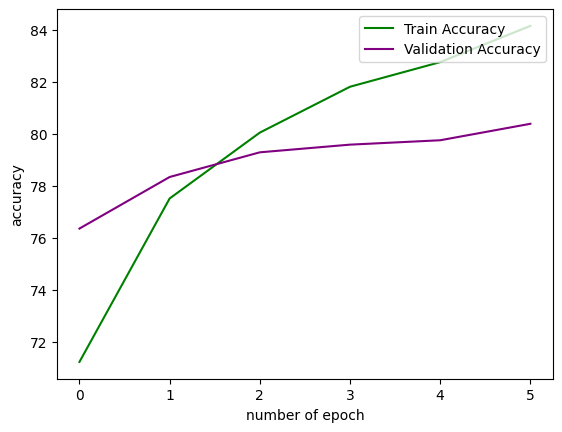

100%|██████████| 150/150 [05:24<00:00,  2.16s/it]


Train- Epoch [7/15], Loss: 1.4699, Accuracy: 85.3237


100%|██████████| 38/38 [00:42<00:00,  1.11s/it]


Validation- Epoch [7/15], Loss: 1.7868, Accuracy: 80.5573


100%|██████████| 31/31 [00:33<00:00,  1.08s/it]


Test- Epoch [7/15], Loss: 2.0022, Accuracy : 78.8050%


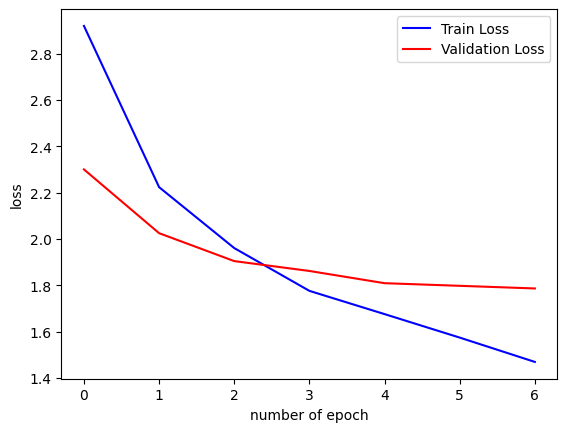

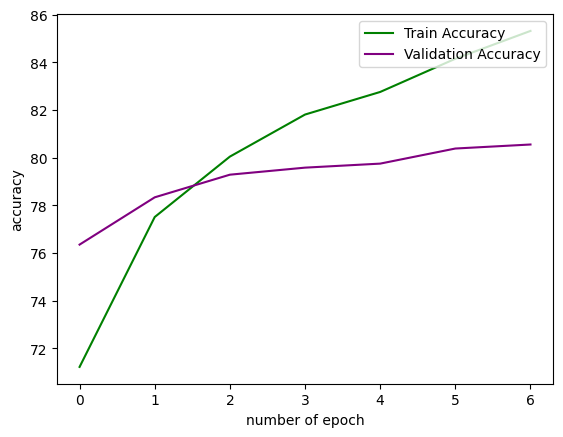

100%|██████████| 150/150 [05:23<00:00,  2.16s/it]


Train- Epoch [8/15], Loss: 1.4019, Accuracy: 86.0413


100%|██████████| 38/38 [00:40<00:00,  1.07s/it]


Validation- Epoch [8/15], Loss: 1.7989, Accuracy: 80.5784


100%|██████████| 31/31 [00:32<00:00,  1.06s/it]


Test- Epoch [8/15], Loss: 1.9958, Accuracy : 78.9853%


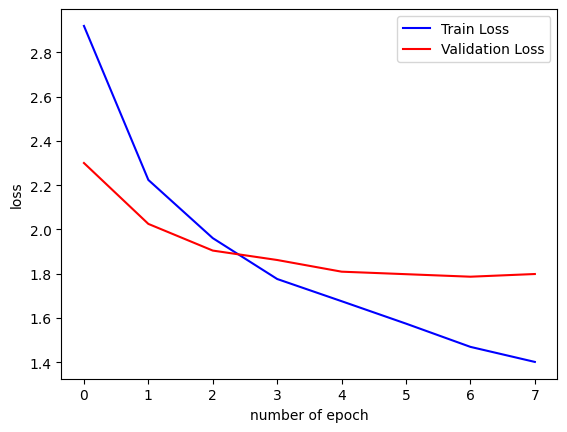

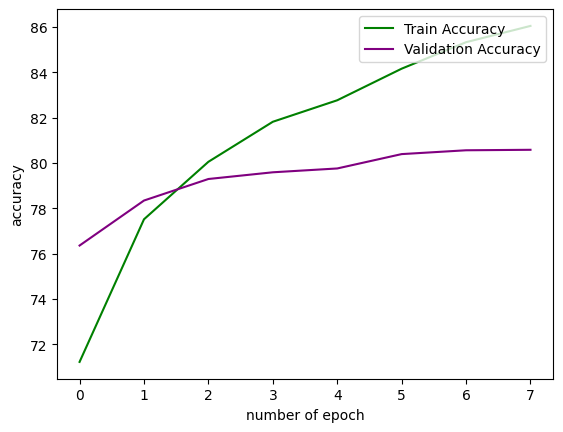

100%|██████████| 150/150 [05:28<00:00,  2.19s/it]


Train- Epoch [9/15], Loss: 1.3269, Accuracy: 87.1569


100%|██████████| 38/38 [00:41<00:00,  1.08s/it]


Validation- Epoch [9/15], Loss: 1.7737, Accuracy: 80.5784


100%|██████████| 31/31 [00:32<00:00,  1.06s/it]


Test- Epoch [9/15], Loss: 1.9851, Accuracy : 78.7535%


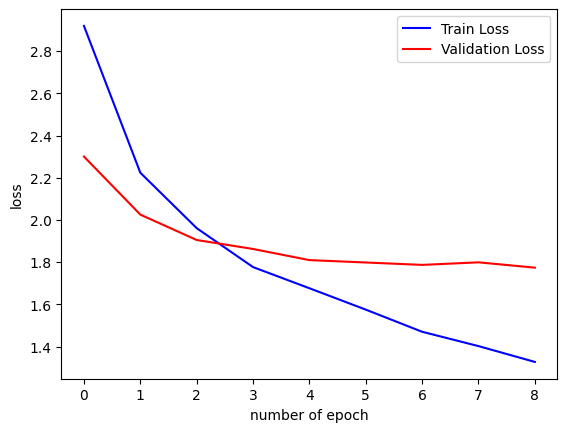

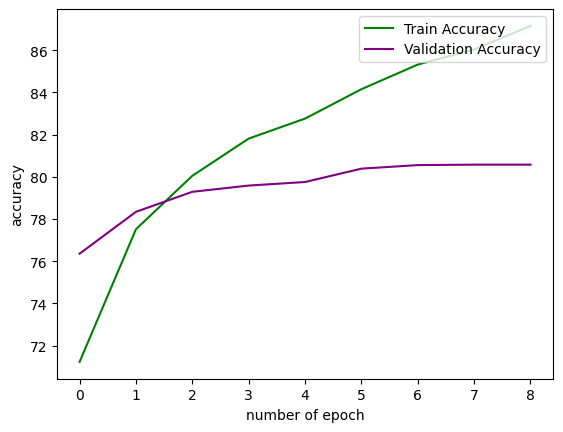

100%|██████████| 150/150 [05:26<00:00,  2.17s/it]


Train- Epoch [10/15], Loss: 1.2784, Accuracy: 87.4502


100%|██████████| 38/38 [00:40<00:00,  1.06s/it]


Validation- Epoch [10/15], Loss: 1.8189, Accuracy: 80.5151


100%|██████████| 31/31 [00:33<00:00,  1.09s/it]

Test- Epoch [10/15], Loss: 1.9758, Accuracy : 79.3201%


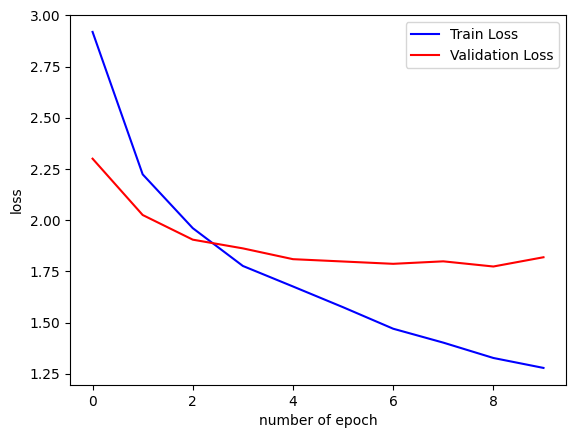

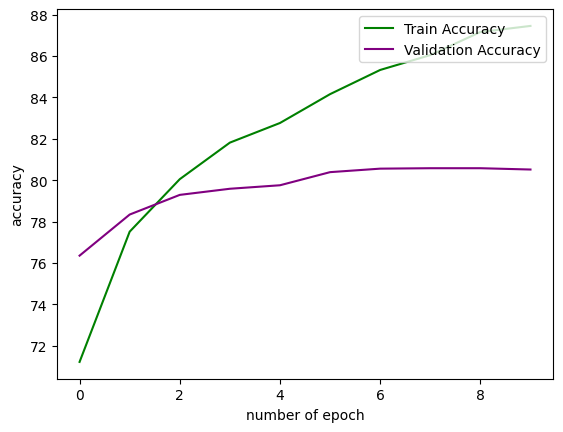

100%|██████████| 150/150 [05:26<00:00,  2.18s/it]


Train- Epoch [11/15], Loss: 1.2009, Accuracy: 88.1835


100%|██████████| 38/38 [00:40<00:00,  1.06s/it]


Validation- Epoch [11/15], Loss: 1.7703, Accuracy: 80.5995


100%|██████████| 31/31 [00:33<00:00,  1.09s/it]


Test- Epoch [11/15], Loss: 1.9746, Accuracy : 79.3201%


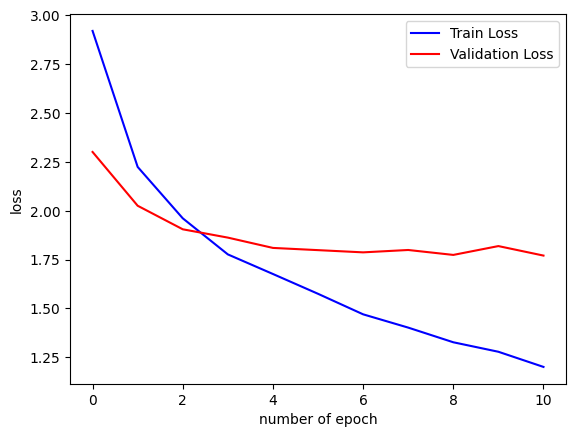

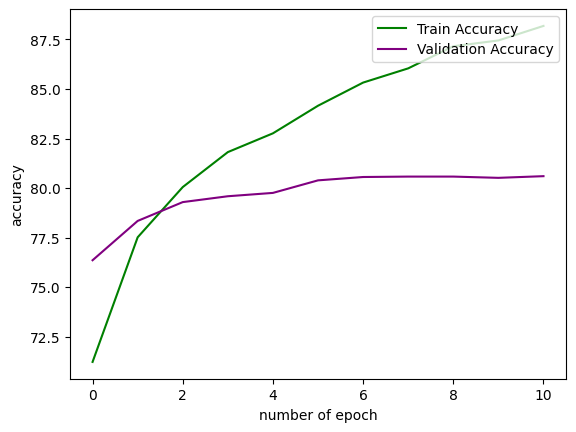

100%|██████████| 150/150 [05:23<00:00,  2.16s/it]


Train- Epoch [12/15], Loss: 1.1386, Accuracy: 88.9011


100%|██████████| 38/38 [00:41<00:00,  1.10s/it]


Validation- Epoch [12/15], Loss: 1.7856, Accuracy: 81.0640


100%|██████████| 31/31 [00:34<00:00,  1.10s/it]


Test- Epoch [12/15], Loss: 1.9682, Accuracy : 79.5519%


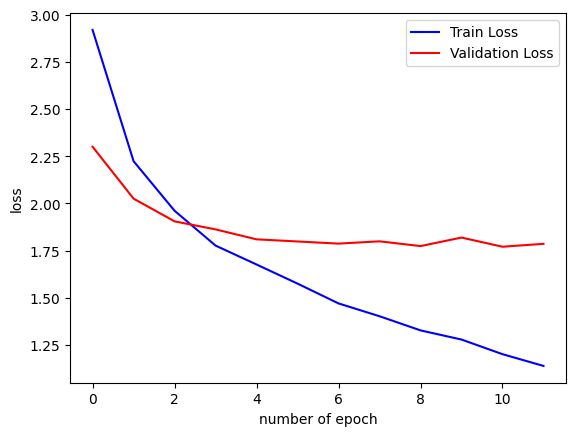

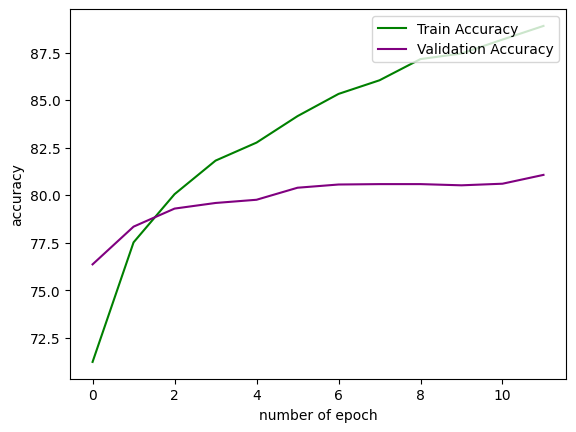

100%|██████████| 150/150 [05:24<00:00,  2.16s/it]


Train- Epoch [13/15], Loss: 1.0914, Accuracy: 89.3673


100%|██████████| 38/38 [00:40<00:00,  1.06s/it]


Validation- Epoch [13/15], Loss: 1.9033, Accuracy: 81.0006


100%|██████████| 31/31 [00:33<00:00,  1.08s/it]


Test- Epoch [13/15], Loss: 1.9786, Accuracy : 79.6292%


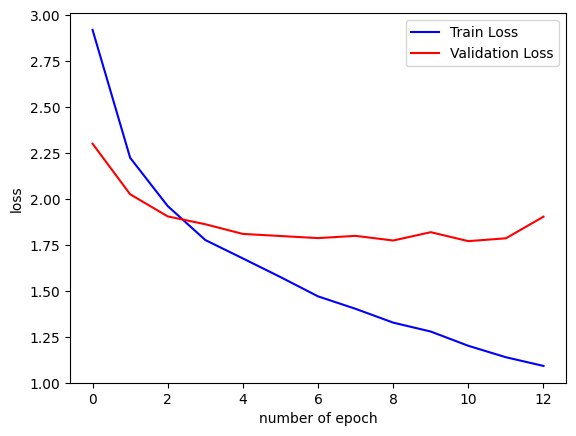

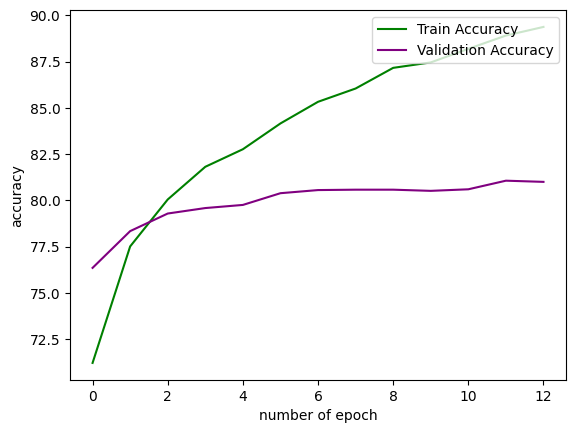

100%|██████████| 150/150 [05:28<00:00,  2.19s/it]


Train- Epoch [14/15], Loss: 1.0499, Accuracy: 90.0115


100%|██████████| 38/38 [00:40<00:00,  1.08s/it]


Validation- Epoch [14/15], Loss: 1.7787, Accuracy: 80.9162


100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Test- Epoch [14/15], Loss: 1.9953, Accuracy : 79.3974%


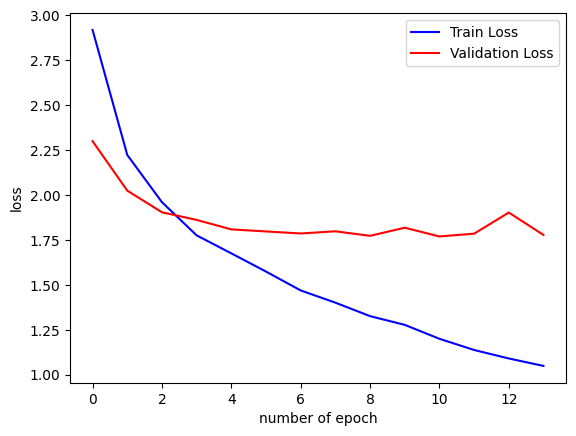

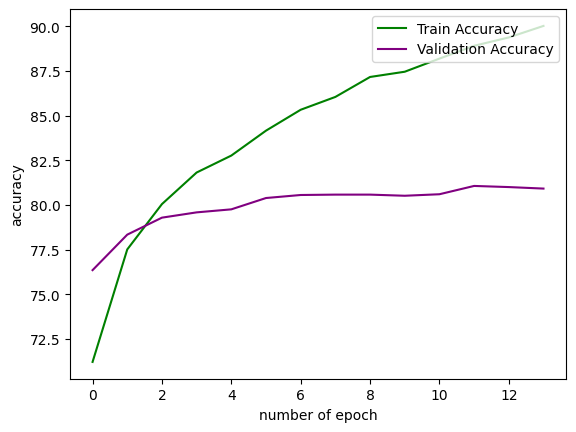

100%|██████████| 150/150 [05:32<00:00,  2.22s/it]


Train- Epoch [15/15], Loss: 0.9893, Accuracy: 90.5982


100%|██████████| 38/38 [00:40<00:00,  1.06s/it]


Validation- Epoch [15/15], Loss: 1.7895, Accuracy: 80.8318


100%|██████████| 31/31 [00:36<00:00,  1.18s/it]


Test- Epoch [15/15], Loss: 1.9905, Accuracy : 79.5261%


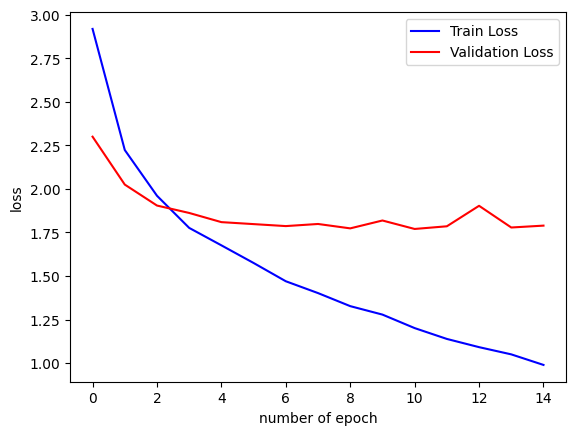

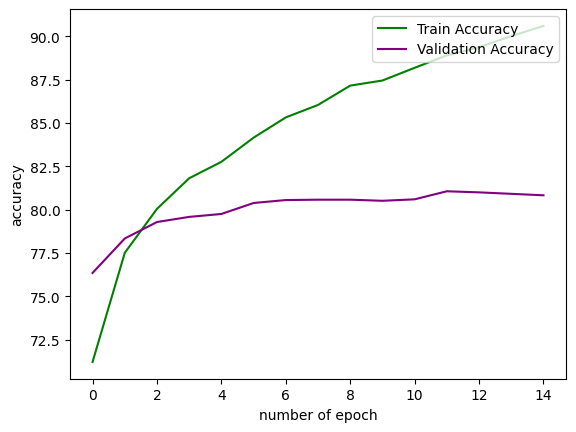

In [ ]:
train_losses = []
train_accuracies = []
train_counter = []

val_losses = []
val_accuracies = []
val_counter = []

test_losses = []
test_accuracies = []
test_counter = []

num_epochs = 15

model.to(device)

for epoch in range(num_epochs):
    n_train_samples = 0
    train_loss = 0.0
    n_train_correct = 0
    n_val_correct = 0
    n_val_samples = 0
    val_loss = 0.0
    train_counter.append(epoch)
    val_counter.append(epoch)
    test_counter.append(epoch)

    model.train()
    for i, (img1, img2, img3) in enumerate(tqdm(train_dataloader)):
        img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)
        n_train_samples += img1.size(0)
        optimizer.zero_grad()
        embedding1, embedding2, embedding3 = model(img1, img2, img3)
        loss, pos_dist, neg_dist = loss_fn(embedding1, embedding2, embedding3)
        loss.backward()
        optimizer.step()

        correct = (pos_dist < neg_dist).float().sum().item()

        train_loss += loss.item()
        n_train_correct += correct


    epoch_train_loss = train_loss / len(train_dataloader)
    train_losses.append(epoch_train_loss)
    epoch_train_acc = (n_train_correct / n_train_samples) * 100
    train_accuracies.append(epoch_train_acc)

    print(f'Train- Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_train_loss:.4f}, Accuracy: {epoch_train_acc:.4f}')


    model.eval()
    with torch.no_grad():
        for i, (img1, img2, img3) in enumerate(tqdm(valid_dataloader)):
            img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)
            n_val_samples +=  img1.size(0)

            embedding1, embedding2, embedding3 = model(img1, img2, img3)
            loss, pos_dist, neg_dist = loss_fn(embedding1, embedding2, embedding3)
            correct = (pos_dist < neg_dist).float().sum().item()

            val_loss += loss.item()
            n_val_correct += correct

        epoch_val_loss = val_loss / len(valid_dataloader)
        val_losses.append(epoch_val_loss)
        epoch_val_acc = (n_val_correct / n_val_samples) * 100
        val_accuracies.append(epoch_val_acc)

        print(f'Validation- Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_acc:.4f}')

        test_counter.append(epoch)
        test_loss = 0.0
        n_test_correct = 0
        n_test_samples = 0

        for i, (img1, img2, img3) in enumerate(tqdm(test_dataloader)):
            n_test_samples +=  img1.size(0)
            img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)

            embedding1, embedding2, embedding3 = model(img1, img2, img3)
            loss, pos_dist, neg_dist = loss_fn(embedding1, embedding2, embedding3)
            correct = (pos_dist < neg_dist).float().sum().item()

            test_loss += loss.item()
            n_test_correct += correct

        epoch_test_acc = (n_test_correct / n_test_samples) * 100
        test_accuracies.append(epoch_test_acc)
        epoch_test_loss = test_loss / len(test_dataloader)
        test_losses.append(epoch_test_loss)

        print(f'Test- Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_test_loss:.4f}, Accuracy : {epoch_test_acc:.4f}%')

    plot(train_counter, train_losses, val_counter, val_losses, val_accuracies, train_accuracies)
    torch.save(model.state_dict(), r"/content/drive/MyDrive/Colab/Deep_Learning/Project/model" + str(epoch) + ".pth")

>These plots represent the best results achieved (epoch 12):

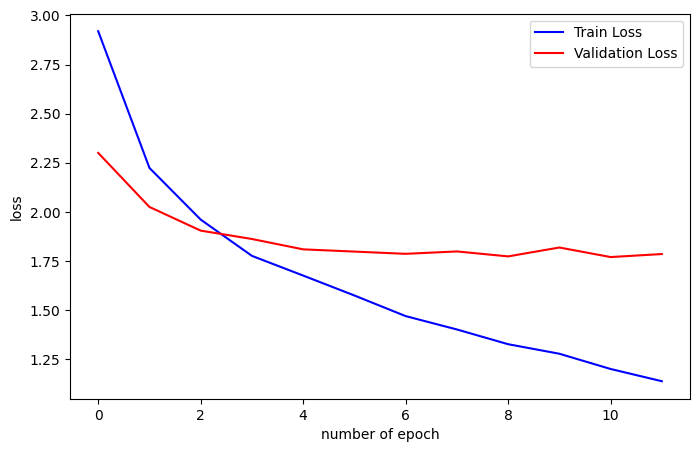

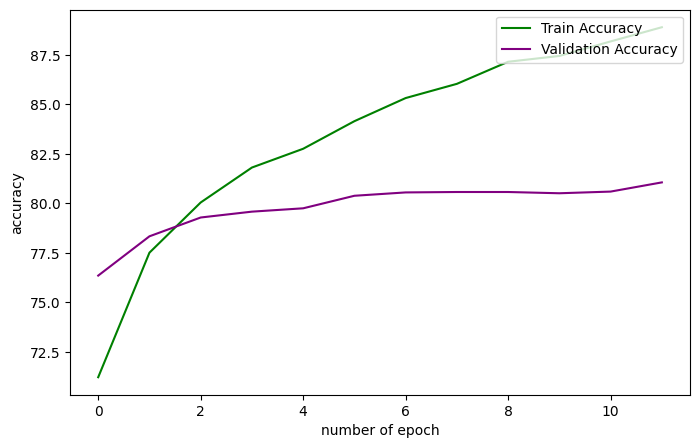

In [ ]:
plot (train_counter, train_losses, val_counter, val_losses, val_accuracies, train_accuracies)

>Best Test Accuracy (epoch 12):

In [ ]:
n_test_samples = 0
test_loss = 0.0
n_test_correct = 0
model = TripletNetwork().to(device)
loss_fn = TripletLoss()

# Load your model
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab/Deep_Learning/Project/Artists_project_model.pth'))
with torch.no_grad():
    model.eval()
    for i, (img1, img2, img3) in enumerate(tqdm(test_dataloader)):
                n_test_samples +=  img1.size(0)
                img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)

                embedding1, embedding2, embedding3 = model(img1, img2, img3)
                loss, pos_dist, neg_dist = loss_fn(embedding1, embedding2, embedding3)
                correct = (pos_dist < neg_dist).float().sum().item()

                test_loss += loss.item()
                n_test_correct += correct

    epoch_test_acc = (n_test_correct / n_test_samples) * 100
    epoch_test_loss = test_loss / len(test_dataloader)

    print(f'Test- Loss: {epoch_test_loss:.4f}, Accuracy : {epoch_test_acc:.4f}%')

100%|██████████| 61/61 [00:33<00:00,  1.84it/s]

Test- Loss: 1.9622, Accuracy : 79.5519%
